# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

In [2]:
! pip install xgboost

     |████████████████████████████████| 1.8 MB 10.9 MB/s eta 0:00:01     |████████████▍                   | 706 kB 10.9 MB/s eta 0:00:01


In [4]:
! pip install catboost

     |████████████████████████████████| 22.0 MB 10.6 MB/s eta 0:00:01


Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [5]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [6]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 1.37 s, sys: 235 ms, total: 1.6 s
Wall time: 1.75 s


,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,...,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60,record,fraud_label
0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
2,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0
3,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0
4,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'max_count_by_address_30',
 'max_count_by_ssn_30',
 'max_count_by_homephone_7',
 'max_count_by_fulladdress_30',
 'address_count_0_by_7',
 'max_count_by_address_7',
 'max_count_by_fulladdress_3',
 'max_count_by_address_3',
 'max_count_by_address_1',
 'max_count_by_fulladdress_1']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_30,max_count_by_homephone_7,max_count_by_fulladdress_30,address_count_0_by_7,max_count_by_address_7,max_count_by_fulladdress_3,max_count_by_address_3,max_count_by_address_1,max_count_by_fulladdress_1
0,1,0,1,1,5,1,7.0,1,1,1,1,1
1,2,1,1,1,6,1,7.0,1,1,1,1,1
2,3,0,1,1,3,1,7.0,1,1,1,1,1
3,4,0,1,1,4,1,7.0,1,1,1,1,1
4,5,0,1,1,4,1,7.0,1,1,1,1,1


In [5]:
vars.shape

(1000000, 12)

In [6]:
vars['Fraud'].sum()

14393

In [7]:
vars.head(10)

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_30,max_count_by_homephone_7,max_count_by_fulladdress_30,address_count_0_by_7,max_count_by_address_7,max_count_by_fulladdress_3,max_count_by_address_3,max_count_by_address_1,max_count_by_fulladdress_1
0,1,0,1,1,5,1,7.0,1,1,1,1,1
1,2,1,1,1,6,1,7.0,1,1,1,1,1
2,3,0,1,1,3,1,7.0,1,1,1,1,1
3,4,0,1,1,4,1,7.0,1,1,1,1,1
4,5,0,1,1,4,1,7.0,1,1,1,1,1
5,6,0,1,1,5,1,7.0,1,1,1,1,1
6,7,0,1,1,4,1,7.0,1,1,1,1,1
7,8,0,1,1,2,1,7.0,1,1,1,1,1
8,9,0,1,1,5,1,7.0,1,1,1,1,1
9,10,0,1,1,5,1,7.0,1,1,1,1,1


In [8]:
vars.shape

(1000000, 12)

In [9]:
vars.describe()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_30,max_count_by_homephone_7,max_count_by_fulladdress_30,address_count_0_by_7,max_count_by_address_7,max_count_by_fulladdress_3,max_count_by_address_3,max_count_by_address_1,max_count_by_fulladdress_1
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,1.178930,1.113723,4.357193,1.143051,6.948009,1.101156,1.067321,1.077955,1.058391,1.051617
std,288675.278933,0.119104,1.152529,0.870793,2.225114,1.080913,0.453021,1.019914,0.930585,0.944963,0.844109,0.833280
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.318182,1.000000,1.000000,1.000000,1.000000,1.000000
25%,250000.750000,0.000000,1.000000,1.000000,3.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,500000.500000,0.000000,1.000000,1.000000,4.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,750000.250000,0.000000,1.000000,1.000000,5.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1000000.000000,1.000000,30.000000,34.000000,33.000000,30.000000,7.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,1
2,0
3,0
4,0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,max_count_by_address_30,max_count_by_ssn_30,max_count_by_homephone_7,max_count_by_fulladdress_30,address_count_0_by_7,max_count_by_address_7,max_count_by_fulladdress_3,max_count_by_address_3,max_count_by_address_1,max_count_by_fulladdress_1
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.178930,1.113723,4.357193,1.143051,6.948009,1.101156,1.067321,1.077955,1.058391,1.051617
std,1.152529,0.870793,2.225114,1.080913,0.453021,1.019914,0.930585,0.944963,0.844109,0.833280
min,1.000000,1.000000,1.000000,1.000000,0.318182,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,4.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,30.000000,34.000000,33.000000,30.000000,7.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,max_count_by_address_30,max_count_by_ssn_30,max_count_by_homephone_7,max_count_by_fulladdress_30,address_count_0_by_7,max_count_by_address_7,max_count_by_fulladdress_3,max_count_by_address_3,max_count_by_address_1,max_count_by_fulladdress_1
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.534784e-14,2.322101e-14,-2.454075e-15,2.126701e-15,4.334560e-14,-5.008516e-14,3.539990e-14,-4.334902e-15,7.088637e-15,-1.562770e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.552499e-01,-1.305970e-01,-1.508774e+00,-1.323428e-01,-1.463470e+01,-9.918091e-02,-7.234270e-02,-8.249530e-02,-6.917471e-02,-6.194437e-02
25%,-1.552499e-01,-1.305970e-01,-6.099432e-01,-1.323428e-01,1.147648e-01,-9.918091e-02,-7.234270e-02,-8.249530e-02,-6.917471e-02,-6.194437e-02
50%,-1.552499e-01,-1.305970e-01,-1.605280e-01,-1.323428e-01,1.147648e-01,-9.918091e-02,-7.234270e-02,-8.249530e-02,-6.917471e-02,-6.194437e-02
75%,-1.552499e-01,-1.305970e-01,2.888873e-01,-1.323428e-01,1.147648e-01,-9.918091e-02,-7.234270e-02,-8.249530e-02,-6.917471e-02,-6.194437e-02
max,2.500680e+01,3.776589e+01,1.287251e+01,2.669683e+01,1.147648e-01,2.833459e+01,3.109086e+01,3.060654e+01,3.428657e+01,3.474029e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [19]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

CPU times: user 1.02 s, sys: 24.9 ms, total: 1.04 s
Wall time: 485 ms


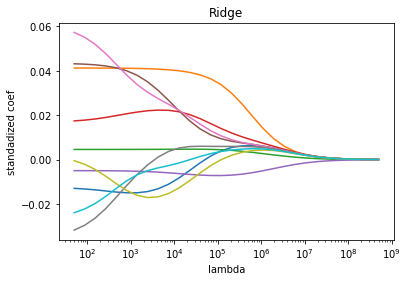

In [20]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [21]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [22]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
CPU times: user 10min 28s, sys: 4.21 s, total: 10min 32s
Wall time: 2min 39s


No handles with labels found to put in legend.


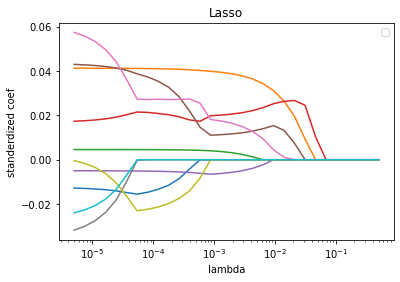

In [23]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [24]:
len(X_trntst.columns)

10

In [25]:
X_trntst_save = X_trntst.copy()

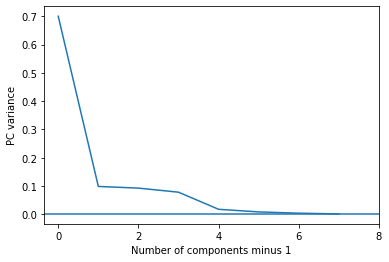

In [26]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [27]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.247388,-0.137037,0.323666,-0.001731,-0.057763,0.004063
1,-0.202519,-0.115640,0.768106,-0.045709,-0.060338,0.009652
2,-0.337125,-0.179832,-0.565214,0.086225,-0.052614,-0.007114
3,-0.292256,-0.158435,-0.120774,0.042247,-0.055189,-0.001526
4,-0.292256,-0.158435,-0.120774,0.042247,-0.055189,-0.001526


In [28]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
833507,-0.247388,-0.137037,0.323666,-0.001731,-0.057763,0.004063
833508,-0.426863,-0.222626,-1.454093,0.174180,-0.047465,-0.018292
833509,0.418185,1.042019,0.240957,0.346512,0.785465,-0.297464
833510,-0.381994,-0.201229,-1.009653,0.130202,-0.050040,-0.012703
833511,-0.337125,-0.179832,-0.565214,0.086225,-0.052614,-0.007114


In [29]:
X_trntst.describe()

,max_count_by_address_30,max_count_by_ssn_30,max_count_by_homephone_7,max_count_by_fulladdress_30,address_count_0_by_7,max_count_by_address_7,max_count_by_fulladdress_3,max_count_by_address_3,max_count_by_address_1,max_count_by_fulladdress_1
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.001774,-0.000490,-0.000450,0.001991,-0.000232,0.001611,0.001656,0.001653,0.001664,0.001683
std,1.005450,0.981617,0.998151,1.007109,1.001414,1.012061,1.014183,1.013762,1.017152,1.017417
min,-0.155250,-0.130597,-1.508774,-0.132343,-14.634699,-0.099181,-0.072343,-0.082495,-0.069175,-0.061944
25%,-0.155250,-0.130597,-0.609943,-0.132343,0.114765,-0.099181,-0.072343,-0.082495,-0.069175,-0.061944
50%,-0.155250,-0.130597,-0.160528,-0.132343,0.114765,-0.099181,-0.072343,-0.082495,-0.069175,-0.061944
75%,-0.155250,-0.130597,0.288887,-0.132343,0.114765,-0.099181,-0.072343,-0.082495,-0.069175,-0.061944
max,25.006804,37.765885,12.872514,26.696832,0.114765,28.334590,31.090863,30.606540,34.286573,34.740287


In [30]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,-0.026565,0.004474,0.004908,-0.002622,-0.002848,0.001391
std,2.459009,1.088811,0.968510,0.892951,0.441280,0.298015
min,-0.426863,-7.828976,-5.562343,-11.873788,-6.801517,-4.405797
25%,-0.292256,-0.179832,-0.565214,-0.001731,-0.057763,-0.007114
50%,-0.247388,-0.158435,-0.120774,0.042247,-0.055189,-0.001526
75%,-0.202519,-0.135137,0.323666,0.086225,-0.052614,0.004063
max,81.727018,29.725867,12.767980,15.265878,14.049509,23.836084


In [31]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [32]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,2.759796e-14,-1.578236e-14,-2.068630e-15,1.115084e-15,-1.053249e-14,-1.540734e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.601823e-01,-8.466088e+00,-8.332107e+00,-1.313603e+01,-1.584921e+01,-1.427948e+01
25%,-1.096706e-01,-1.801850e-01,-5.841255e-01,-1.947357e-03,-1.375819e-01,-2.479841e-02
50%,-9.283340e-02,-1.587458e-01,-1.248149e-01,4.753267e-02,-1.314500e-01,-5.317943e-03
75%,-7.599618e-02,-1.158673e-01,3.344956e-01,9.701269e-02,-1.253181e-01,1.416253e-02
max,3.011428e+01,3.522541e+01,1.319519e+01,1.861078e+01,3.301278e+01,8.308602e+01


In [33]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,-0.009969,0.004482,0.005072,-0.002950,-0.006782,0.004849
std,0.922755,1.090950,1.000916,1.004672,1.051051,1.038798
min,-0.160182,-7.844350,-5.748456,-13.359371,-16.200023,-15.357394
25%,-0.109671,-0.180185,-0.584125,-0.001947,-0.137582,-0.024798
50%,-0.092833,-0.158746,-0.124815,0.047533,-0.131450,-0.005318
75%,-0.075996,-0.135403,0.334496,0.097013,-0.125318,0.014163
max,30.668469,29.784240,13.195191,17.175862,33.463473,83.086023


In [34]:
X_trntst_pca.shape

(833507, 6)

In [35]:
X_oot_orig_pca.shape

(166493, 6)

## Subsample the larger class if desired

In [36]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 10) 23841


In [37]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [38]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [39]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=20)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

/Users/stevecoggeshall/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0 0.5733588425206265 0.5746432491767288 0.549455155071249


/Users/stevecoggeshall/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 0.569368295589988 0.5769975117500691 0.5461022632020117


/Users/stevecoggeshall/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 0.5686695278969958 0.58469190384084 0.5486169321039397


/Users/stevecoggeshall/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 0.5712753277711561 0.5761680951064418 0.5477787091366303


/Users/stevecoggeshall/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4 0.5708195168166745 0.5745158574235195 0.5465213746856664
trn    0.570698
tst    0.577403
oot    0.547695
dtype: float64
CPU times: user 16.6 s, sys: 582 ms, total: 17.2 s
Wall time: 4.51 s


In [40]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=2,min_samples_split=1000,min_samples_leaf=500)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.4896625475285171 0.4706209969367864 0.45347862531433364
1 0.48979832527420686 0.48781179138321995 0.4631181894383906
2 0.48095859532566143 0.4882615986584684 0.45347862531433364
3 0.49091343854615016 0.48888278891023884 0.4631181894383906
4 0.4888208990350671 0.48760330578512395 0.4631181894383906
trn    0.488031
tst    0.484636
oot    0.459262
dtype: float64
CPU times: user 2.36 s, sys: 269 ms, total: 2.63 s
Wall time: 2.23 s


In [41]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=3,max_depth=2,min_samples_split=1000,min_samples_leaf=500,max_features=8)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.48574122083431537 0.5052541891508094 0.4631181894383906
1 0.4821407239278461 0.49504950495049505 0.46018440905280805
2 0.48518164435946465 0.4869469634514977 0.4543168482816429
3 0.49060217885789537 0.4909688013136289 0.46269907795473597
4 0.5417459562321598 0.5454292859127535 0.5155071248952221
trn    0.497082
tst    0.504730
oot    0.471165
dtype: float64
CPU times: user 3.88 s, sys: 501 ms, total: 4.38 s
Wall time: 4.44 s


In [42]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5418491772226826 0.5384831460674158 0.5146689019279128
1 0.5404950732996876 0.5383989145183175 0.5125733445096395
2 0.5341756919374248 0.5472004327833379 0.5125733445096395
3 0.5427069645203679 0.5341034103410341 0.5146689019279128
4 0.5436098255606978 0.538268156424581 0.5146689019279128
trn    0.540567
tst    0.539291
oot    0.513831
dtype: float64
CPU times: user 24.3 s, sys: 1.58 s, total: 25.9 s
Wall time: 4.19 s


In [43]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5731329038415652 0.5649655172413793 0.548197820620285
1 0.5792356232884868 0.5698447893569845 0.5532271584241408
2 0.5774496963924277 0.573170731707317 0.5490360435875943
3 0.5815198002140564 0.5825458588104503 0.5565800502933781
4 0.5558478832815116 0.5665294924554184 0.5322715842414082
trn    0.573437
tst    0.571411
oot    0.547863
dtype: float64
CPU times: user 1min 14s, sys: 768 ms, total: 1min 15s
Wall time: 1min 10s


In [44]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5767065446868402 0.5731111749497271 0.5507124895222129
1 0.568895279175653 0.5714285714285714 0.5423302598491199
2 0.566888045540797 0.566993006993007 0.5339480301760269
3 0.5845347313237221 0.5902047592695074 0.5611902766135792
4 0.57956186807896 0.5844822925114896 0.5540653813914501
trn    0.575317
tst    0.577244
oot    0.548449
dtype: float64
CPU times: user 1min 2s, sys: 504 ms, total: 1min 2s
Wall time: 57.7 s


In [45]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5909364106262772 0.591648590021692 0.567476948868399
1 0.5938643067846607 0.5838052095130238 0.5678960603520536
2 0.5898622981956315 0.5900083728718951 0.5611902766135792
3 0.598698224852071 0.5892606128760192 0.5708298407376362
4 0.5997116770783277 0.5875644854737986 0.5704107292539815
trn    0.594615
tst    0.588457
oot    0.567561
dtype: float64
CPU times: user 5.67 s, sys: 760 ms, total: 6.43 s
Wall time: 5.98 s


In [46]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5445438282647584 0.5342352291551629 0.5134115674769488
1 0.5408842405514619 0.5430002783189535 0.5134115674769488
2 0.5370545197073401 0.5516558165864704 0.5134115674769488
3 0.5375894988066826 0.5492142266335814 0.5134115674769488
4 0.5435664836476486 0.5384403416919261 0.5134115674769488
trn    0.540728
tst    0.543309
oot    0.513412
dtype: float64
CPU times: user 5.45 s, sys: 551 ms, total: 6 s
Wall time: 3.39 s


In [47]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

68.41842258682435
0 0.5964853835262763 0.5964853835262763 0.5716680637049455
1 0.5957358207712168 0.5957358207712168 0.5720871751886002
2 0.5964020987757142 0.5964020987757142 0.5716680637049455
3 0.5960689597734655 0.5960689597734655 0.5720871751886002
4 0.5959856750229033 0.5959856750229033 0.5704107292539815
trn    0.596136
tst    0.596136
oot    0.571584
dtype: float64
CPU times: user 2.57 s, sys: 596 ms, total: 3.17 s
Wall time: 2.67 s


In [48]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5408685306365258 0.5399777901166019 0.5134115674769488
1 0.5399881164587047 0.5473273942093542 0.5134115674769488
2 0.5566714490674318 0.5479000823497118 0.5272422464375524
3 0.5439153439153439 0.5405482581382067 0.5142497904442582
4 0.5694162588038677 0.5589531680440771 0.5393964794635373
trn    0.550172
tst    0.546941
oot    0.521542
dtype: float64
CPU times: user 4.67 s, sys: 306 ms, total: 4.98 s
Wall time: 2.43 s


In [49]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5559905100830368 0.5457086944366788 0.519279128248114
1 0.5557547508067407 0.5464285714285714 0.519279128248114
2 0.5499702911467618 0.5601336302895323 0.519279128248114
3 0.5525876460767947 0.5526097763048882 0.519279128248114
4 0.5505590958278226 0.5582655826558266 0.519279128248114
trn    0.552972
tst    0.552629
oot    0.519279
dtype: float64
CPU times: user 1.53 s, sys: 246 ms, total: 1.77 s
Wall time: 1.77 s


In [50]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=2, n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5414443258626823 0.5481253497481813 0.5155071248952221
1 0.5441211260941566 0.5378553335209681 0.5155071248952221
2 0.5464493874152492 0.5322222222222223 0.5155071248952221
3 0.5405179615705932 0.5490628445424476 0.5155071248952221
4 0.539570044885424 0.5495622705450438 0.5155071248952221
trn    0.542421
tst    0.543366
oot    0.515507
dtype: float64
CPU times: user 28.7 s, sys: 1.04 s, total: 29.7 s
Wall time: 4.17 s


In [51]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [53]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.573359,0.574643,0.549455
1,log reg,0.569368,0.576998,0.546102
2,log reg,0.56867,0.584692,0.548617
3,log reg,0.571275,0.576168,0.547779
4,log reg,0.57082,0.574516,0.546521
5,DT,0.489663,0.470621,0.453479
6,DT,0.489798,0.487812,0.463118
7,DT,0.480959,0.488262,0.453479
8,DT,0.490913,0.488883,0.463118
9,DT,0.488821,0.487603,0.463118


In [54]:
df.shape

(60, 4)

In [55]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.573359
1,log reg,Trn,0.569368
2,log reg,Trn,0.56867
3,log reg,Trn,0.571275
4,log reg,Trn,0.57082


In [56]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.573359
1,log reg,Trn,0.569368
2,log reg,Trn,0.56867
3,log reg,Trn,0.571275
4,log reg,Trn,0.57082


In [57]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT  \
                           mean       std      mean       std      mean   
Model                                                                     
DT                     0.488031  0.004023  0.484636  0.007850  0.459262   
GBC                    0.594615  0.004453  0.588457  0.002986  0.567561   
LGBM                   0.540567  0.003753  0.539291  0.004795  0.513831   
NN                     0.573437  0.010302  0.571411  0.006980  0.547863   
NN_PCs                 0.575317  0.007369  0.577244  0.009700  0.548449   
RF                     0.497082  0.025151  0.504730  0.023749  0.471165   
XGB                    0.542421  0.002821  0.543366  0.007875  0.515507   
cat boost              0.540728  0.003391  0.543309  0.007257  0.513412   
cat boost_PCs          0.550172  0.012669  0.546941  0.007660  0.521542   
cat boost_sampled      0.596136  0.000308  0.596136  0.000308  0.571584   
log reg                0.570698  0.001824  0.577403  0.004206  0.547695   
unsupervised outliers  0.552972  0.002821  0.552629  0.006604  0.519279   

                                 
                            std  
Model                            
DT                     0.005280  
GBC                    0.003857  
LGBM                   0.001148  
NN                     0.009345  
NN_PCs                 0.010568  
RF                     0.025035  
XGB                    0.000000  
cat boost              0.000000  
cat boost_PCs          0.011583  
cat boost_sampled      0.000689  
log reg                0.001403  
unsupervised outliers  0.000000

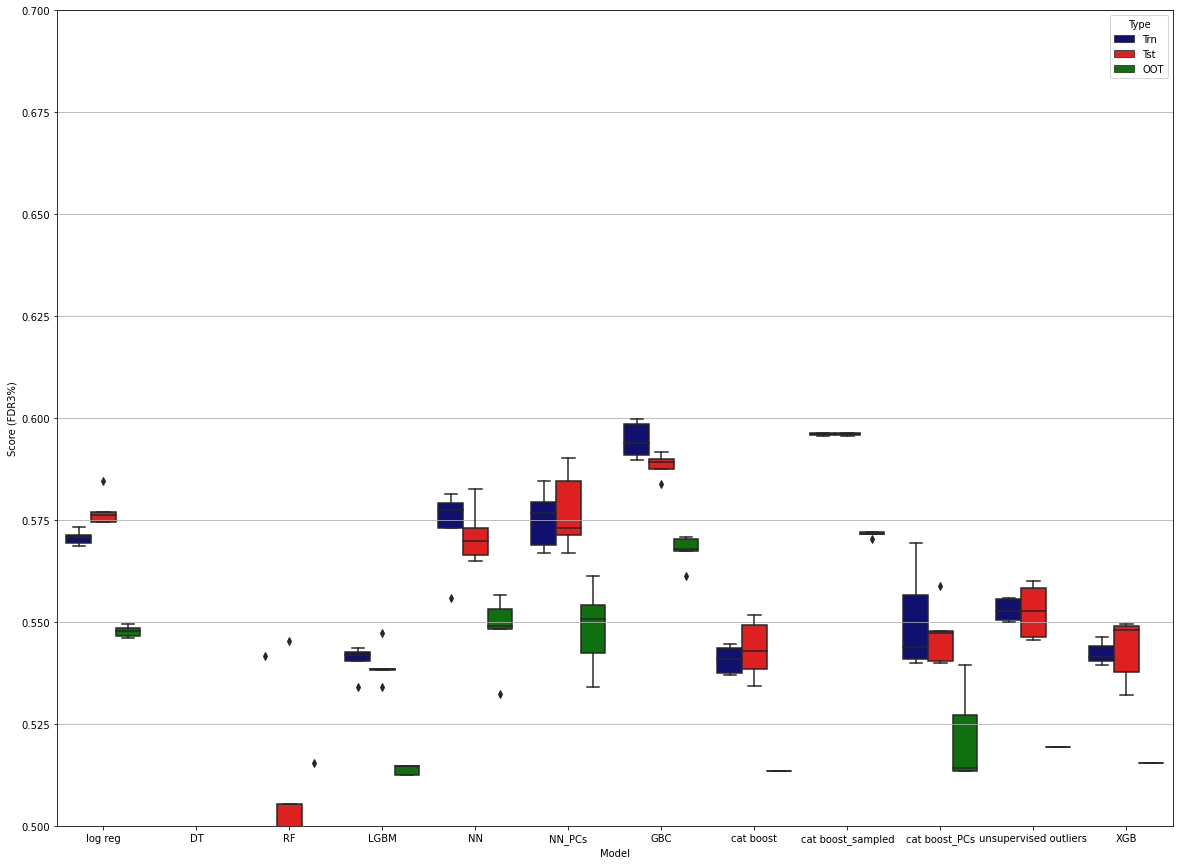

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [59]:
print('duration: ', datetime.now() - start_time)

duration:  0:05:33.669446


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [60]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = CatBoostClassifier(verbose=0, iterations=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6097156398104265 0.582282029716849 0.5750209555741828
trn    0.556075
tst    0.550197
oot    0.527410
dtype: float64
CPU times: user 11.2 s, sys: 290 ms, total: 11.5 s
Wall time: 2.37 s


In [61]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [62]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,max_count_by_address_30,max_count_by_ssn_30,max_count_by_homephone_7,max_count_by_fulladdress_30,address_count_0_by_7,max_count_by_address_7,max_count_by_fulladdress_3,max_count_by_address_3,max_count_by_address_1,max_count_by_fulladdress_1,predicted,Fraud
836311,9.388977,-0.130597,-1.059358,10.044241,-13.791872,10.686042,11.748184,11.558173,12.962316,13.138902,0.996862,0
882392,11.124292,-0.130597,4.333624,11.894529,-13.791872,11.666517,12.822777,12.616416,14.146997,14.338979,0.996433,1
893691,9.388977,-0.130597,3.884209,10.044241,-14.049402,10.686042,11.748184,11.558173,11.777635,11.938825,0.996309,0
885088,15.462577,-0.130597,7.479531,16.520249,-14.049402,17.549366,19.270337,18.965871,21.255083,21.539441,0.995961,1
915152,25.006804,-0.130597,12.872514,26.696832,-13.791872,28.334590,31.090863,30.606540,34.286573,34.740287,0.995792,1
915252,17.197891,-0.130597,3.434794,18.370537,-14.428123,17.549366,14.971963,14.732901,12.962316,13.138902,0.995632,1
913364,17.197891,-0.130597,3.434794,18.370537,-13.620185,17.549366,14.971963,14.732901,12.962316,13.138902,0.995469,1
920789,15.462577,-0.130597,5.681870,16.520249,-14.049402,15.588417,11.748184,11.558173,8.223592,8.338594,0.995390,1
923284,15.462577,-0.130597,5.681870,16.520249,-14.233353,15.588417,11.748184,11.558173,8.223592,8.338594,0.995390,1
918372,15.462577,-0.130597,5.681870,16.520249,-13.932343,15.588417,11.748184,11.558173,8.223592,8.338594,0.995390,1


In [63]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,500.0,1165.0,30.030030,69.969970,1665.0,500.0,1165.0,0.304679,48.826488,48.521809,0.429185
2,2.0,1665.0,1518.0,147.0,91.171171,8.828829,3330.0,2018.0,1312.0,1.229686,54.987427,53.757741,1.538110
3,3.0,1665.0,1605.0,60.0,96.396396,3.603604,4995.0,3623.0,1372.0,2.207706,57.502096,55.294390,2.640671
4,4.0,1665.0,1651.0,14.0,99.159159,0.840841,6660.0,5274.0,1386.0,3.213757,58.088852,54.875095,3.805195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1654.0,11.0,99.339339,0.660661,159833.0,157482.0,2351.0,95.963000,98.533110,2.570110,66.985113
97,97.0,1665.0,1659.0,6.0,99.639640,0.360360,161498.0,159141.0,2357.0,96.973926,98.784577,1.810651,67.518456
98,98.0,1665.0,1653.0,12.0,99.279279,0.720721,163163.0,160794.0,2369.0,97.981195,99.287510,1.306315,67.874209
99,99.0,1665.0,1656.0,9.0,99.459459,0.540541,164828.0,162450.0,2378.0,98.990293,99.664711,0.674418,68.313709


In [64]:
FDR3.to_csv('FDR3.csv')

In [65]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [66]:
print("duration: ", datetime.now() - start_time)

duration:  0:05:39.437525
